In [103]:
using ITensors

N = 100 # sites used for constructing the maximal Hilbert space.
NumDelta = 4 # points on phase diagram we will study
pdls = zeros(NumDelta) # labeling points in the phase diagram

sites = siteinds("S=1", N, conserve_qns = true) # site indices.
states = [isodd(n) ? "Up" : "Dn" for n=1:N] # to conserve QNs, set psi to a specific initial state

els = ones(NumDelta) # Ground state energies list
pls = [randomMPS(sites, states, 2) for i=1:NumDelta] # Ground state wavefunctions list


# Experiment parameters
J = 1 # Hopping strength as the energy unit
UU = 10 * J #  The intraspecies interaction (= ua = ub)
for delta in (1:NumDelta)
    Uab = UU * (0.9 + 0.02*delta) # The interspecies interaction
    Jxyz = 4 * J^2 / Uab # Ferro-Heisenberg interaction strength
    u = UU - Uab # Sz^2 on site strength
    pdls[delta] = u/Jxyz
    println("u/Jxyz=", pdls[delta])
    els[delta], pls[delta] =
    let
        # Parameters of the effective spin model
        Jz = -1.0 * Jxyz
        Jv = -0.5 * Jxyz

        # Using AutoMPO to construct Hamiltonian, similar to pen-and-paper notation!
        ampo = AutoMPO()
        # Ferro-Hersenberg term
        for j=1:N-1
            ampo += Jv,"S+",j,"S-",j+1
            ampo += Jv,"S-",j,"S+",j+1
            ampo += Jz,"Sz",j,"Sz",j+1
        end
        # On-site Sz^2 term
        for j = 1:N
            ampo += u,"Sz",j,"Sz",j
        end
        # Convert to the MPO form
        H = MPO(ampo,sites)

        # Sweep number and accurary
        sweeps = Sweeps(6) # Number of sweeps
        maxdim!(sweeps,10,20,100,100,200) # Gradually increase states kept (i.e., bound dimension)
        cutoff!(sweeps,1E-10) # Truncation error for SVD

        psi0 = randomMPS(sites, states, 2) # construct a random initial state each time
        # run dmrg algorithm
        dmrg(H, psi0, sweeps)
    end
end

u/Jxyz=1.8399999999999979
After sweep 1 energy=-15.570337325336 maxlinkdim=10 time=0.775
After sweep 2 energy=-16.663040372855 maxlinkdim=20 time=1.425
After sweep 3 energy=-16.984156584044 maxlinkdim=67 time=1.980
After sweep 4 energy=-17.090964719460 maxlinkdim=72 time=2.271
After sweep 5 energy=-17.111063643169 maxlinkdim=88 time=2.346
After sweep 6 energy=-17.119662467606 maxlinkdim=90 time=2.377
u/Jxyz=1.4099999999999993
After sweep 1 energy=-19.338095241996 maxlinkdim=10 time=0.769
After sweep 2 energy=-20.255422501521 maxlinkdim=20 time=1.507
After sweep 3 energy=-20.370658251443 maxlinkdim=64 time=2.058
After sweep 4 energy=-20.423550575612 maxlinkdim=76 time=2.436
After sweep 5 energy=-20.456135101687 maxlinkdim=99 time=2.593
After sweep 6 energy=-20.472441094838 maxlinkdim=85 time=2.750
u/Jxyz=0.9600000000000009
After sweep 1 energy=-23.985160546719 maxlinkdim=10 time=0.770
After sweep 2 energy=-25.086692086027 maxlinkdim=20 time=1.540
After sweep 3 energy=-25.196982998544 ma

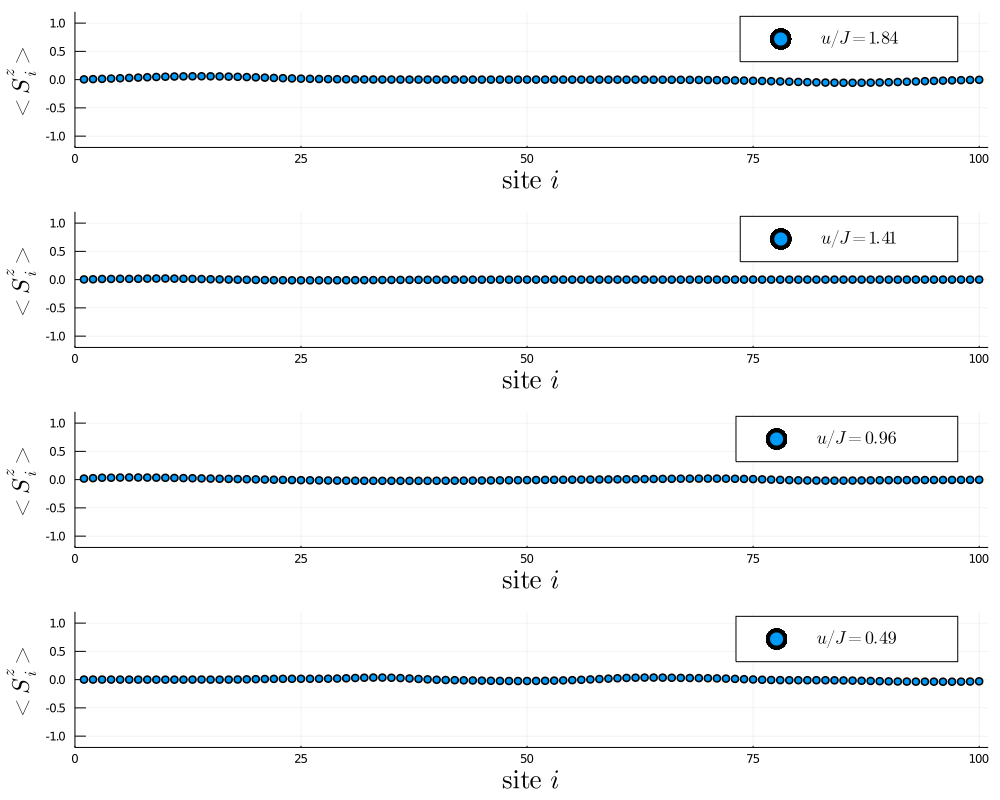

In [3]:
# <Sz_i>
using Plots
using LaTeXStrings

opevls = zeros(NumDelta, N)
for i in (1:NumDelta)
    psi = copy(pls[i])
    for j=1:N
        orthogonalize!(psi,j)
        opevls[i, j] = scalar(psi[j] * op(siteind(psi,j),"Sz") * dag(prime(psi[j],siteind(psi,j))))
    end
end

scatter([1:N], opevls', layout = (NumDelta, 1), label = reshape([latexstring("u / J = $(round(pdls[l],digits = 2))") for l in (1:NumDelta)],1,NumDelta),  xlims = (0, 101), ylims = (-1.2, 1.2), xlab = L"\textrm{site } i", ylab = L"<S_i^z>", yguidefontsize=16, xguidefontsize=18, legendfontsize=12, size=(1000,800))

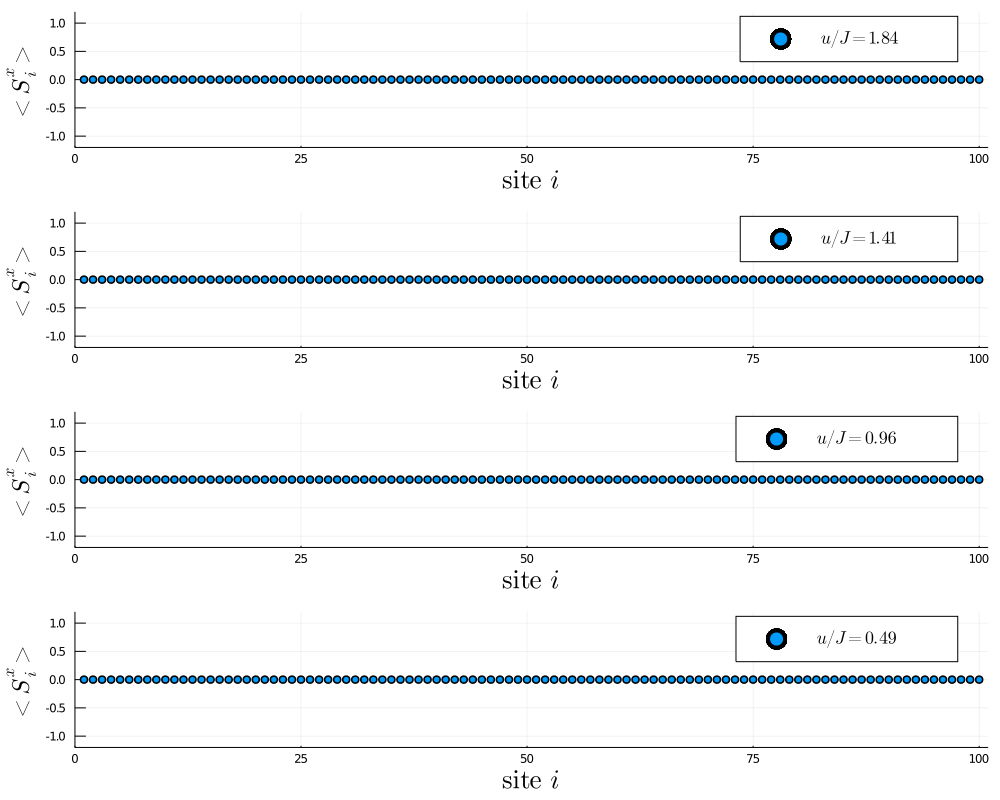

In [4]:
# There is a missing functionality in current version of ITensor, namely, one can not remove the QNs of MPS (or ITensors),
# hence the desired contraction can not be done!
using Plots
using LaTeXStrings

opevls = ones(NumDelta, N)
for i in (1:NumDelta)
    psi = copy(pls[i])
    for j=1:N
        orthogonalize!(psi,j)
        opevls[i, j] = scalar(dense(psi[j]) * dense(op(removeqns(siteind(psi,j)),"Sx")) * dense(dag(prime(psi[j],siteind(psi,j)))))
    end
end

scatter([1:N], opevls', layout = (NumDelta, 1), label = reshape([latexstring("u / J = $(round(pdls[l],digits = 2))") for l in (1:NumDelta)],1,NumDelta),  xlims = (0, 101), ylims = (-1.2, 1.2), xlab = L"\textrm{site } i", ylab = L"<S_i^x>", yguidefontsize=16, xguidefontsize=18, legendfontsize=12, size=(1000,800))

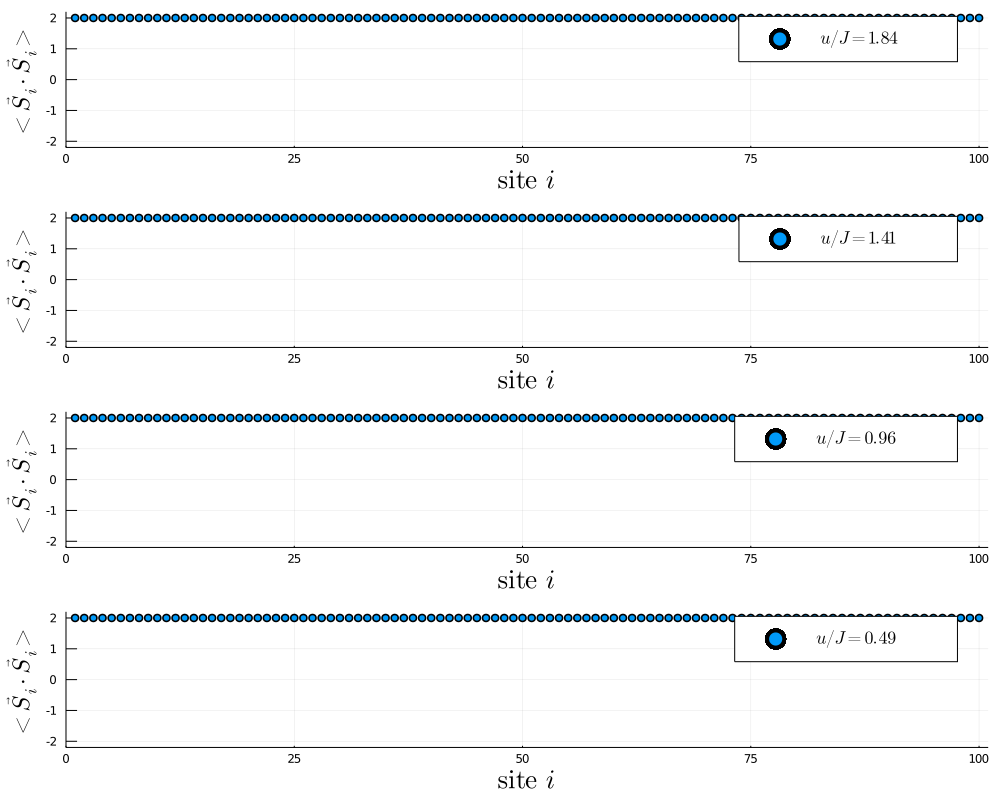

In [6]:
# There is a missing functionality in current version of ITensor, namely, one can not remove the QNs of MPS (or ITensors),
# hence the desired contraction can not be done!
using Plots
using LaTeXStrings

opevls = zeros(NumDelta, N)
for i in (1:NumDelta)
    psi = pls[i]
    for j=1:N
        orthogonalize!(psi,j)
        opevls[i, j] = scalar(dense(psi[j]) * dense(mapprime(op(removeqns(siteind(psi,j)),"Sx")*prime(op(removeqns(siteind(psi,j)),"Sx")),2,1) + mapprime(op(removeqns(siteind(psi,j)),"Sy")*prime(op(removeqns(siteind(psi,j)),"Sy")),2,1) +
                mapprime(op(removeqns(siteind(psi,j)),"Sz")*prime(op(removeqns(siteind(psi,j)),"Sz")),2,1)) * dense(dag(prime(psi[j],siteind(psi,j)))) )
    end
end

scatter([1:N], opevls', layout = (NumDelta, 1),
    label = reshape([latexstring("u / J = $(round(pdls[l],digits = 2))") for l in (1:NumDelta)],1,NumDelta),
    xlims = (0, 101), ylims = (-2.2, 2.2), xlab = L"\textrm{site } i", ylab = L"<\vec S_i \cdot \vec S_i>",
    yguidefontsize=16, xguidefontsize=18, legendfontsize=12, size=(1000,800))

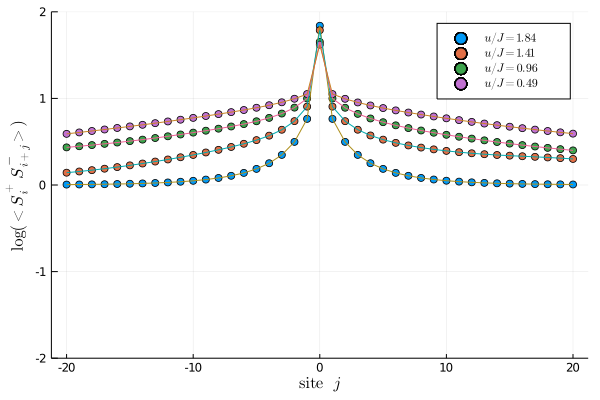

In [104]:
# two-point correlation function (Algorithm explained in http://www.itensor.org/docs.cgi?page=tutorials/correlations&vers=cppv3)

dj = trunc(Int, 1/5*N) # maximal distance in correlation function
centr = trunc(Int, N / 2) # chain centr
ls1 = zeros(NumDelta, 2 * dj + 1) # correlation function list

let
    for i in (1:NumDelta)
        psi = orthogonalize(pls[i],centr) # orthogonalize centr at the centr
        Splus = op("Splus",siteind(psi, centr)) # S+ at the centr
        for j in (-dj:dj) # different distance in correlation function
            Sminus = op("Sminus",siteind(psi, centr + j)) # S- at the (N/2+j)th site
            C = psi[centr] # contraction start from centr
            C *= Splus # contract with S+ at centr
            if j == 0
                noprime!(C) # if j = 0, unprime the site index
                C *= Sminus # then contract S- at 50th site
                ls1[i,j+dj+1] = scalar(C * dag(prime(psi[centr],siteind(psi,centr)))) # then contract with psi^dagger at (N/2)th site
            elseif j<0
                ci = commoninds(psi[centr],psi[centr-1])
                C *= dag(prime(prime(psi[centr],"Site"),ci)) # if j < 0, contract with site and RIGHT indices of psi^dagger at 50th site.
                if j < -1 
                    for j1 in (1:-j-1) # for j = 49, 48, ..., 50 + j + 1
                        C *= psi[centr-j1]
                        C *= dag(prime(psi[centr-j1],"Link"))
                    end
                end
                C *= psi[centr+j] # finally the (50 + j)th site
                C *= Sminus
                ci = commoninds(psi[centr + j], psi[centr + j + 1])
                C *= dag(prime(prime(psi[centr+j],"Site"),ci))
                ls1[i,j+dj+1] = scalar(C)
            else            
                ci = commoninds(psi[centr], psi[centr+1])
                C *= dag(prime(prime(psi[centr],"Site"),ci)) # for j > 0, it is similar
                if j > 1
                    for j1 in (1:j-1)
                        C *= psi[centr+j1]
                        C *= dag(prime(psi[centr+j1],"Link"))
                    end
                end
                C *= psi[centr+j]
                C *= Sminus
                ci = commoninds(psi[centr + j], psi[centr + j - 1])
                C *= dag(prime(prime(psi[centr+j],"Site"),ci))
                ls1[i,j+dj+1] = scalar(C)
            end
        end
    end
end

# plot([1:length(psi)], opev)
scatter([-dj:dj], ls1', ylims = (-2,2),
            label = reshape([latexstring("u / J = $(round(pdls[l],digits = 2))") for l in (1:NumDelta)],1,NumDelta),
            xlab = L"\textrm{site }\ j", ylab = L"\log(<S^+_i S^-_{i+j}>)")
plot!([-dj:dj], ls1', label = false)

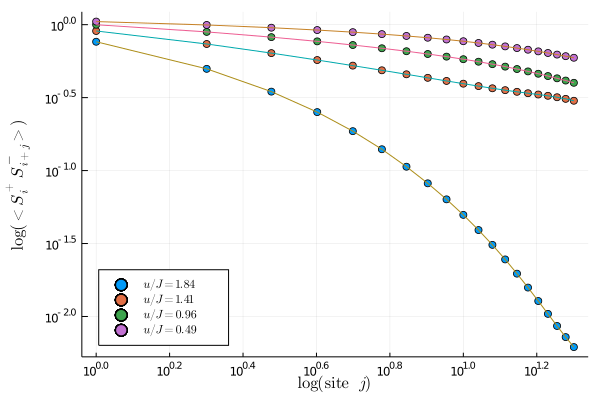

In [113]:
scatter([1:dj], ls1[:,dj+2:2*dj+1]',
            label = reshape([latexstring("u / J = $(round(pdls[l],digits = 2))") for l in (1:NumDelta)],1,NumDelta),
            xlab = L"\log(\textrm{site }\ j)", ylab = L"\log(<S^+_i S^-_{i+j}>)",
            xaxis=:log, yaxis=:log,
            legend = :bottomleft)
plot!([1:dj], ls1[:,dj+2:2*dj+1]', label = false)